In [0]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from shutil import copyfile

# Load dataset and set up training and testing directories

In [0]:
# !rm -r /tmp/*
local_zip = '/content/characters.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/characters-dataset/')
zip_ref.close()

In [0]:
!ls /tmp/characters-dataset/

0  2  4  6  8  A  C  E	G  I  K  M  O  Q  S  U	W  Y
1  3  5  7  9  B  D  F	H  J  L  N  P  R  T  V	X  Z


In [0]:
chars = [chr(ord('A') + i) for i in range(26)] + [chr(ord('0') + i) for i in range(10)] 
print(*chars)

A B C D E F G H I J K L M N O P Q R S T U V W X Y Z 0 1 2 3 4 5 6 7 8 9


In [0]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [0]:
#!rm -r /tmp/characters/*

In [0]:
for char in chars:
  os.makedirs(f'/tmp/characters/training/{char}')
  os.makedirs(f'/tmp/characters/testing/{char}')
  # os.makedirs(f'/tmp/characters/train_and_val/{char}')
  # os.makedirs(f'/tmp/characters/validation/{char}')

In [0]:
split_size = .90
for char in chars:
    SOURCE_DIR = f'/tmp/characters-dataset/{char}/'
    TRAIN_DIR = f'/tmp/characters/training/{char}/'
    TEST_DIR = f'/tmp/characters/testing/{char}/'
    split_data(SOURCE_DIR, TRAIN_DIR, TEST_DIR, split_size)

## Make training and validation split

In [0]:
# !mv /tmp/characters/training /tmp/characters/train_and_val

In [0]:
# split_size = .8
# for char in chars:
#     SOURCE_DIR = f'/tmp/characters/train_and_val/{char}/'
#     TRAIN_DIR = f'/tmp/characters/training/{char}/'
#     VAL_DIR = f'/tmp/characters/validation/{char}/'
#     split_data(SOURCE_DIR, TRAIN_DIR, VAL_DIR, split_size)

In [0]:
# !rm -r /tmp/characters/*

In [0]:
print(len(os.listdir('/tmp/characters/training/P')),
# len(os.listdir('/tmp/characters/validation/P')),
len(os.listdir('/tmp/characters/testing/P')))

265 30


# Define and train model

In [0]:
model = tf.keras.models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(30, 30, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPool2D(2, 2),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(36, activation='softmax')
])

# model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['acc'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1180672   
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

## Define Data Generators

In [0]:
TRAIN_DIR = "/tmp/characters/training/"
TEST_DIR = "/tmp/characters/testing/"
VAL_DIR = "/tmp/characters/validation/"

# create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(30, 30),
    class_mode='categorical',
    batch_size=16,
)

# validation_datagen = ImageDataGenerator(
#       rotation_range=40,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       fill_mode='nearest'
# )

# validation_generator = validation_datagen.flow_from_directory(
#     VAL_DIR,
#     target_size=(30, 30),
#     class_mode="categorical"
# )

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_generator = train_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(30, 30),
    class_mode='categorical',
    batch_size=16,
)

Found 9540 images belonging to 36 classes.
Found 1080 images belonging to 36 classes.


In [0]:
history = model.fit_generator(
    train_generator,
    epochs=50,
    verbose=1,
    validation_data=test_generator
)

Epoch 1/50
597/597 [==============================] - 9s 15ms/step - loss: 2.2796 - acc: 0.3176 - val_loss: 1.4366 - val_acc: 0.5500
Epoch 2/50
597/597 [==============================] - 8s 14ms/step - loss: 1.1089 - acc: 0.6369 - val_loss: 1.0098 - val_acc: 0.6898
Epoch 3/50
597/597 [==============================] - 8s 13ms/step - loss: 0.7892 - acc: 0.7375 - val_loss: 0.8245 - val_acc: 0.7417
Epoch 4/50
597/597 [==============================] - 8s 14ms/step - loss: 0.6606 - acc: 0.7766 - val_loss: 0.6559 - val_acc: 0.8056
Epoch 5/50
597/597 [==============================] - 8s 14ms/step - loss: 0.6106 - acc: 0.7977 - val_loss: 0.6087 - val_acc: 0.8019
Epoch 6/50
597/597 [==============================] - 8s 14ms/step - loss: 0.5426 - acc: 0.8160 - val_loss: 0.5116 - val_acc: 0.8426
Epoch 7/50
597/597 [==============================] - 8s 14ms/step - loss: 0.4997 - acc: 0.8317 - val_loss: 0.5852 - val_acc: 0.8139
Epoch 8/50
597/597 [==============================] - 8s 14ms/step - 

<Figure size 432x288 with 0 Axes>

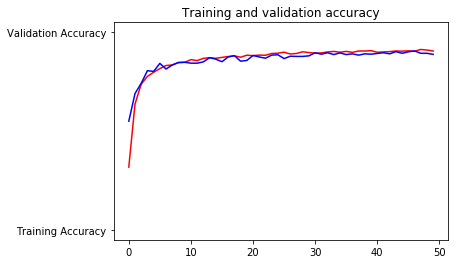

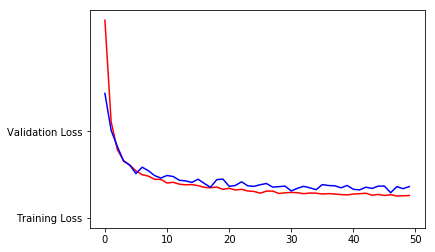

<Figure size 432x288 with 0 Axes>

In [0]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


In [0]:
model.save('./ninety_acc_model.hd5')